<center>
<div style = 'background-color: #504e4e; padding: 30px '>
    <span style='font-size:18px;'>
    <h2>
    Dashboard For YouTube Trending Video Analysis</h2><br>Visit Kaustubh's <a href="https://github.com/kaustubhgupta">GitHub</a> and <a href="https://www.linkedin.com/in/kaustubh-gupta">Linkedin</a> for more projects!
    </span>
    </div>
    </center>

In [1]:
from ipywidgets import interact, fixed
from collections import Counter
from PIL import Image
import pandas as pd
import numpy as np
import ipywidgets as widgets
import wordcloud
import json
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data.csv", na_values=['[None]'])

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
df = reduce_mem_usage(df, verbose=False)

In [5]:
df["description"] = df["description"].fillna(value="")  # filling description as empty strings

In [6]:
df["channelTitle"] = df["channelTitle"].fillna(value="") # filling channel titles as empty strings

In [7]:
df["tags"] = df["tags"].fillna(value="") # filling tags as empty strings

In [8]:
df["trending_date"] = pd.to_datetime(df["trending_date"])  # converting datetime values into standard pandas datetime format

In [9]:
df["publishedAt"] = pd.to_datetime(df["publishedAt"])  # converting datetime values into standard pandas datetime format

In [10]:
df["cleanedTitle"] = df["title"].str.replace(r"[!@#$&|\-\.():,’0-9\U0001F600-\U0001F64F"  
                                        "\U0001F300-\U0001F5FF"  
                                        "\U0001F680-\U0001F6FF" 
                                        "\U0001F1E0-\U0001F1FF" 
                                        "\U00002500-\U00002BEF" 
                                        "\U00002702-\U000027B0"
                                        "\U00002702-\U000027B0"
                                        "\U000024C2-\U0001F251"
                                        "\U0001f926-\U0001f937"
                                        "\U00010000-\U0010ffff"
                                        "\u2640-\u2642" 
                                        "\u2600-\u2B55"
                                        "\u200d"
                                        "\u23cf"
                                        "\u23e9"
                                        "\u231a"
                                        "\ufe0f"
                                        "\u3030"
                                        "]+", '', regex=True)  # https://stackoverflow.com/a/58356570

## Statistical Numbers

In [11]:
stats = df.describe().reset_index()
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['Metric', 'View Count', 'Likes', 'Dislikes', 'Comment Count']),
                align='left'),
    cells=dict(values=[stats['index'], stats.view_count, stats.likes, stats.dislikes, stats.comment_count],
               align='left'))
])

fig.update_layout(template='plotly_dark',
                  font=dict(size=15), 
                 )

fig.show();

## Trending Videos Publishing Trend on Hourly basis

In [12]:
data = df.publishedAt.dt.hour.value_counts()
        
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, 
                         y=data.values,
                         mode='markers',
                         marker=dict(
                             size=20,
                             line_width=2,
                             color=data.values,
                             colorscale='Rainbow',
                             showscale=True
                        )
                    ))

fig.update_layout(xaxis_tickangle=-45,
                  font=dict(size=15),
                  yaxis={'visible': True, 'showticklabels': False},
                  xaxis_title='Hour of Day (24-hour clock)',
                  yaxis_title='Number of Videos',
                  template='plotly_dark', 
                 )

fig.update_layout(hovermode="x")

## Trending Videos Publishing Trend on Weekdays

In [13]:
data = df.publishedAt.dt.day_name().value_counts().to_frame().to_dict()['publishedAt']

fig = go.Figure()
days = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
values = tuple(data[i] for i in days)

fig.add_trace(go.Scatter(x=days, 
                         y=values,
                         mode='lines',
                         name='Trend over weekdays'
                    ))

fig.update_layout(xaxis_tickangle=-45,
                  font=dict(size=15),
                  yaxis={'visible': True, 'showticklabels': True, 'showgrid': False},
                  xaxis_title='Week Days',
                  yaxis_title='Number of Videos',
                  template='plotly_dark', 
                 )

## Bar graph for number of videos per channel

In [14]:
def displayChannels(Top):
    data = df.groupby("channelTitle").size().reset_index(name="video_count").sort_values("video_count", ascending=False).head(Top).reset_index(drop=True)

    fig = px.bar(
                x=data['channelTitle'],
                y=data['video_count'],
                color=data['video_count'],
                labels={'x': "Channel Name", 'color':'Number of Videos'},
                template='plotly_dark',
                text=data['video_count'],
                color_continuous_scale='Rainbow',
                )

    fig.update_layout(xaxis_tickangle=-45,
                    yaxis={'visible': False, 'showticklabels': False},
                    font=dict(size=15),
                    width=1000,
                    height=700
                    )

    fig.show()

interact(displayChannels, Top=widgets.IntSlider(min=10, max=30, step=1, value=10));

interactive(children=(IntSlider(value=10, description='Top', max=30, min=10), Output()), _dom_classes=('widget…

## Bar graph for number of videos per category

In [15]:
with open("in_category_ids.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['categoryId'].map(cat_dict)

In [16]:
data = df["category_name"].value_counts().to_frame().reset_index()

data.rename(columns={"index": "category_name", "category_name": "No_of_videos"}, inplace=True)

fig = px.bar(
            x=data['category_name'],
            y=data['No_of_videos'],
            color=data['No_of_videos'],
            labels={'x': "Category", 'color':'Number of Videos'},
            template='plotly_dark',
            text=data['No_of_videos'],
            color_continuous_scale='Rainbow',
            )

fig.update_layout(xaxis_tickangle=-45,
                yaxis={'visible': False, 'showticklabels': False},
                font=dict(size=15),
                width=1000,
                height=700
                )

## Word Cloud

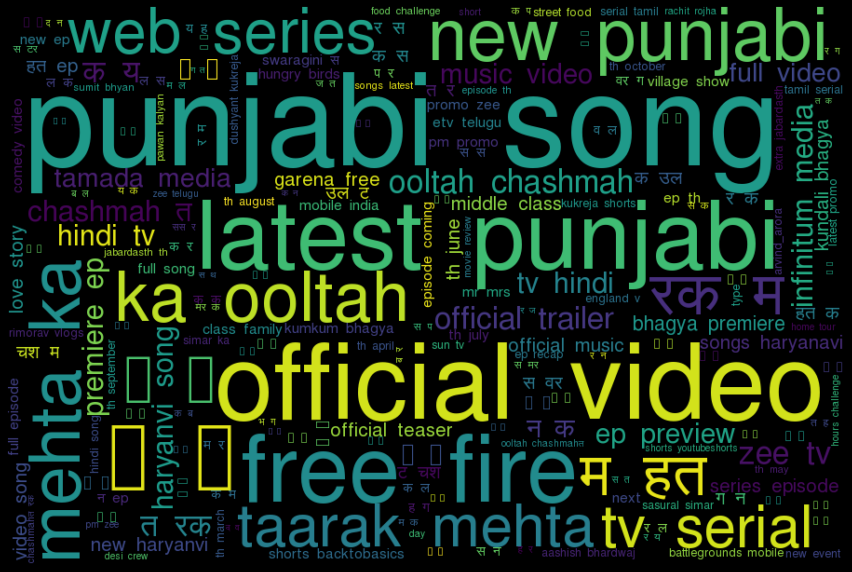

In [17]:
title_words = list(df["cleanedTitle"].str.lower().apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]

font = "hindi_font.ttf"
wc = wordcloud.WordCloud(width=900, height=600,
                         min_font_size = 10, font_path= font,
                         ).generate(" ".join(title_words))

plt.figure(figsize=(12, 10), facecolor='k')
plt.imshow(wc, interpolation="bilinear")
plt.style.use('dark_background')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Is Video Title Fully Capitalized ?

In [18]:
def capitalizedTitle(s):
    state = True
    for w in s.split():
        if w.isupper():
            state = True
        else:
            state = False
            break
    return state


df["capitalizedState"] = df["cleanedTitle"].apply(capitalizedTitle)
value_counts = df["capitalizedState"].value_counts().to_dict()

In [19]:
fig = go.Figure(data=[go.Pie(labels=['No', 'Yes'],
                             values=[value_counts[False], value_counts[True]],
                             textinfo='label+percent',
                             pull=[0.2, 0, 0]
                             )])

fig.update_traces(hoverinfo='label+value',  textfont_size=15, 
                  marker=dict(line=dict(color='#eff542', width=2)), showlegend=False)

fig.update_layout(template='plotly_dark',
                  font=dict(size=15), 
                  )

fig.show();

In [20]:
df["title_length"] = df["cleanedTitle"].apply(lambda x: len(x.split()))

## Distribution of Video Title Length

In [21]:
fig = go.Figure(data=[go.Histogram(x=df["title_length"].values,
                                   text = df["title_length"].values,
                             )])

fig.update_traces(
                  marker=dict(line=dict(width=2)), showlegend=False)

fig.update_layout(template='plotly_dark',
                  font=dict(size=15),
                  )

fig.show();

## Correlations between various features of a video

In [22]:
data = df.corr()
h_labels = [x.replace('_', ' ').title() for x in 
            list(df.select_dtypes(include=['number', 'bool']).columns.values)]

fig = go.Figure(data=[go.Heatmap(z=data.values,
                              x=h_labels,
                              y=h_labels,
                              colorscale = 'RdBu'
                             )])

fig.update_layout(template='plotly_dark',
                  font=dict(size=15), 
                  width=900,
                  height=600
                  )

fig.show();
